In [ ]:
#!pip install PyAthena
#!pip install --upgrade gensim

In [1]:
from __future__ import print_function
import numpy as np
import string
import nltk
from nltk import word_tokenize
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os
import boto3
#from botocore.client import ClientError
# below is used to print out pretty pandas dataframes
from IPython.display import display, HTML

#from pyathena import connect
from pyathena.pandas.util import as_pandas
import torch
import torch.nn as nn
import time
import re
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jdfloresd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
s3 = boto3.resource('s3')
client = boto3.client("sts")
account_id = client.get_caller_identity()["Account"]
my_session = boto3.session.Session()
region = my_session.region_name
athena_query_results_bucket = 'aws-athena-query-results-'+account_id+'-'+region

try:
    s3.meta.client.head_bucket(Bucket=athena_query_results_bucket)
except ClientError:
    bucket = s3.create_bucket(Bucket=athena_query_results_bucket)
    print('Creating bucket '+athena_query_results_bucket)
cursor = connect(s3_staging_dir='s3://'+athena_query_results_bucket+'/athena/temp').cursor()

In [ ]:
query = 'select * from default.diabetic_patients_notes_agg'
cursor.execute(query)
cohort_patients_df = as_pandas(cursor)

In [ ]:
def preprocess_dataset(df):    
    '''
    INPUT: notes dataframe
    OUTPUT: (list) preprocessed clinical notes
    TASK: Preprocess the text data. And return a list of clinical notes. '''
    clinical_notes = []
    
    df.notes_agg = df.notes_agg.fillna(' ')  # remove NA
    df.notes_agg = df.notes_agg.str.replace('\n',' ')  # remove newline
    df.notes_agg = df.notes_agg.str.replace('\r',' ')
    
    
    #remove punctuation 
    df.notes_agg = [re.sub(r'[^\w\s]','',x) for x in df.notes_agg.tolist()]
    df.notes_agg = [re.sub('['+string.punctuation+']','',x) for x in df.notes_agg.tolist()]
    
    #remove numbers
    df.notes_agg = [re.sub("\d+",'',x) for x in df.notes_agg.tolist()]
    
    df.notes_agg = df.notes_agg.str.lower()  # convert to lower case
    
    # tokenize
    for note in df.notes_agg.values:
        note_tokenized = word_tokenize(note)
        clinical_notes.append(note_tokenized)

    return clinical_notes

In [ ]:
from gensim.models import Word2Vec
#preprocess and train the first patient notes with subject_id 13
clinical_notes = preprocess_dataset(cohort_patients_df.loc[cohort_patients_df.subject_id==13])
notes_model = Word2Vec(clinical_notes, vector_size=200, min_count=10, workers=4)

#Update word vector model
for idx in range(1,len(ids)):
    df = cohort_patients_df.loc[cohort_patients_df.subject_id==ids[idx]]
    addition_notes = preprocess_dataset(df)
    notes_model.build_vocab(addition_notes, update=True)
    notes_model.train(addition_notes, total_examples=notes_model.corpus_count, epochs=notes_model.epochs)
    

In [ ]:
#retrieve the keyed vectors
note_vectors = notes_model.wv

#save the keyed vectors
note_vectors.save('note_vectors.kv')

In [3]:
from gensim.models import KeyedVectors
#load the word vector embedding
word_model = KeyedVectors.load('note_vectors.kv')

### Plot the Word Embedding Using TSNE

In [4]:
#embeddings
X = word_model[word_model.key_to_index]

#words
W = list(word_model.key_to_index)

#select subset of words
X_subset = X[:1000]
W_subset = W[:1000]

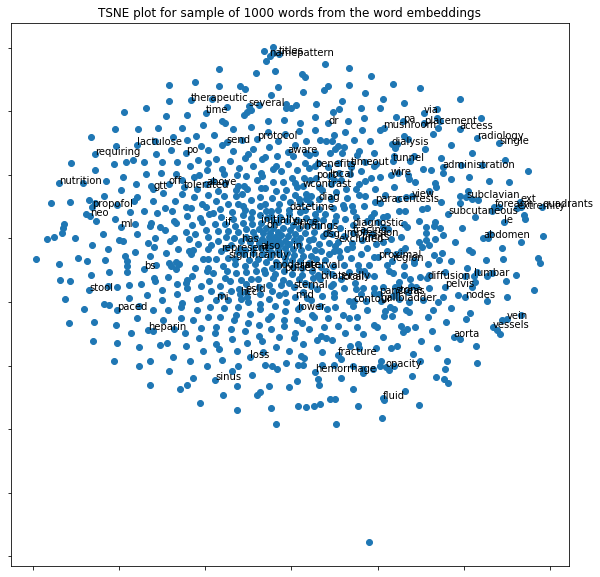

In [5]:
#plot word embeddings
from sklearn.manifold import TSNE
import random

def plot(X,Y,W):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.plot(Y[:,0],Y[:,1],'o')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
    for i, word in enumerate(W):
        if random.uniform(0,1) > 0.9:
            plt.annotate(word, xy=(Y[i,0], Y[i,1]))
    plt.title('TSNE plot for sample of 1000 words from the word embeddings')
    plt.savefig('tsne.png')
    plt.show()
    
Y_subset_tsne = TSNE(random_state=230729).fit_transform(X_subset)

plot(X_subset, Y_subset_tsne, W_subset)